# Overround Revenue Analysis - Multi-Probability Scenarios

Analysis of betting house revenue across multiple overround scenarios (10% to 90%) using three different probability sources:

1. **Logistic Probability (Best Case)**: Our trained prediction model
2. **Market Probability (Intermediate)**: Betting market implied probabilities
3. **Uniform Probability (Worst Case)**: No information scenario (1/n)

This notebook compares actual revenue against expected revenue under each information scenario to understand the value of predictive information.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import the Oscar model trainer module
from oscar_model_trainer import (
    get_predictions,
    calculate_bettors_with_elasticity,
    calculate_betting_house_revenue,
    calculate_expected_revenue
)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Load Predictions from Trained Model

Load the last 5 years of predictions from the logistic regression model.


In [2]:
# Load predictions from the trained model
print("Training logistic regression model and generating predictions...")
predictions = get_predictions(years_back=5)

# Merge with market probabilities
print("\nMerging with market probabilities...")
market_df = pd.read_csv('market_probabilities.csv')
predictions = predictions.merge(
    market_df[['Film', 'market_probability']], 
    on=['Film'], 
    how='left'
)

# make sure the market_probability is a probability
predictions['market_probability'] = predictions.groupby('Year')['market_probability'].transform(
    lambda x: x / x.sum()
)

# Calculate uniform probability (1/n for each year - worst case scenario)
print("Calculating uniform probabilities...")
predictions['uniform_probability'] = predictions.groupby('Year')['Film'].transform(
    lambda x: 1 / len(x)
)

# Calculate fair odds for each probability model
print("Calculating fair odds for each probability model...")
predictions['fair_odds_logistic'] = 1 / predictions['Logistic_Probability']
predictions['fair_odds_market'] = 1 / predictions['market_probability']
predictions['fair_odds_uniform'] = 1 / predictions['uniform_probability']

print(f"\nPredictions loaded successfully!")
print(f"Shape: {predictions.shape}")
print(f"Years covered: {sorted(predictions['Year'].unique())}")
print(f"\nColumns available:")
print(list(predictions.columns))


Training logistic regression model and generating predictions...

Merging with market probabilities...
Calculating uniform probabilities...
Calculating fair odds for each probability model...

Predictions loaded successfully!
Shape: (47, 16)
Years covered: [np.float64(2020.0), np.float64(2021.0), np.float64(2022.0), np.float64(2023.0), np.float64(2024.0)]

Columns available:
['Year', 'Film', 'Actual_Winner', 'Logistic_Probability', 'Logistic_Predicted_Winner', 'Training_Size', 'fair_odds', 'implied_probability', 'belief_mean', 'belief_std', 'prop_active_bettors', 'market_probability', 'uniform_probability', 'fair_odds_logistic', 'fair_odds_market', 'fair_odds_uniform']


In [3]:
# Display sample predictions with all three probability sources
print("Sample predictions with all probability sources:")
print("\nProbability Sources:")
print("  - Logistic_Probability: Model prediction (best case - we have predictive model)")
print("  - market_probability: Betting market odds (intermediate - market information)")
print("  - uniform_probability: 1/n (worst case - no information)")
predictions[['Year', 'Film', 'Actual_Winner', 'Logistic_Probability', 
             'market_probability', 'uniform_probability', 
             'fair_odds_logistic', 'fair_odds_market', 'fair_odds_uniform', 'prop_active_bettors']]


Sample predictions with all probability sources:

Probability Sources:
  - Logistic_Probability: Model prediction (best case - we have predictive model)
  - market_probability: Betting market odds (intermediate - market information)
  - uniform_probability: 1/n (worst case - no information)


,Year,Film,Actual_Winner,Logistic_Probability,market_probability,uniform_probability,fair_odds_logistic,fair_odds_market,fair_odds_uniform,prop_active_bettors
0,2020.0,Nomadland,1,0.227612,0.215319,0.166667,4.393436,4.644267,6.0,0.100712
1,2020.0,The Father,0,0.183470,0.107660,0.166667,5.450491,9.288464,6.0,0.125127
2,2020.0,Mank,0,0.144525,0.153800,0.166667,6.919223,6.501964,6.0,0.185148
3,2020.0,Minari,0,0.161001,0.179433,0.166667,6.211137,5.573112,6.0,0.170905
4,2020.0,Promising Young Woman,0,0.103640,0.153800,0.166667,9.648739,6.501964,6.0,0.267548
5,2020.0,The Trial of the Chicago 7,0,0.179752,0.189988,0.166667,5.563235,5.263492,6.0,0.150560
6,2021.0,King Richard,0,0.116670,0.100471,0.090909,8.571176,9.953090,11.0,0.036000
7,2021.0,The Power of the Dog,0,0.085221,0.140660,0.090909,11.734222,7.109361,11.0,0.067000
8,2021.0,Nightmare Alley,0,0.071591,0.055524,0.090909,13.968147,18.010192,11.0,0.105000
9,2021.0,West Side Story,0,0.064999,0.111047,0.090909,15.384800,9.005181,11.0,0.130000


## 2. Configure Overround Scenarios

Test overrounds from 10% to 90% with 10% increments.

Using elasticity of -0.7: as overround increases, number of bettors decreases.


In [4]:
# Configuration
BASE_BETTORS = 1000      # Number of bettors at base overround
BASE_OVERROUND = 0.1     # Reference overround (10%)
BET_AMOUNT = 1
ELASTICITY = -1

# Generate overround scenarios
overrounds = np.arange(0.01, 0.21, 0.01)

overround_scenarios = []
for overround in overrounds:
    bettors = calculate_bettors_with_elasticity(
        BASE_BETTORS, BASE_OVERROUND, overround, ELASTICITY
    )
    label = f"{int(overround*100)}% Overround"
    overround_scenarios.append((overround, bettors, label))

# Display scenarios
print("Overround Scenarios:")
print("-" * 50)
print(f"{'Overround':<15} {'Bettors':<15} {'Label'}")
print("-" * 50)
for overround, bettors, label in overround_scenarios:
    print(f"{overround:.1%} {bettors:<15} {label}")


Overround Scenarios:
--------------------------------------------------
Overround       Bettors         Label
--------------------------------------------------
1.0% 1900            1% Overround
2.0% 1799            2% Overround
3.0% 1700            3% Overround
4.0% 1600            4% Overround
5.0% 1500            5% Overround
6.0% 1400            6% Overround
7.0% 1300            6% Overround
8.0% 1200            8% Overround
9.0% 1100            9% Overround
10.0% 1000            10% Overround
11.0% 900             11% Overround
12.0% 800             12% Overround
13.0% 700             13% Overround
14.0% 599             14% Overround
15.0% 499             15% Overround
16.0% 400             16% Overround
17.0% 299             17% Overround
18.0% 199             18% Overround
19.0% 100             19% Overround
20.0% 0               20% Overround


## 3. Calculate Actual Revenue

Calculate the actual revenue the betting house would have earned based on real Oscar winners.


In [5]:

# Calculate actual revenue for each overround scenario
# Using fair_odds_logistic since the house uses our model to set odds
actual_revenue_multiple_models = {}
fair_odds_cols = ['fair_odds_logistic', 'fair_odds_market', 'fair_odds_uniform']

for odds in fair_odds_cols:
    actual_revenue_results = {}
    for overround, bettors, label in overround_scenarios:
        revenue_df = calculate_betting_house_revenue(
            predictions, 
            overround=overround, 
            total_bettors=bettors,
            bet_amount=BET_AMOUNT,
            fair_odds_col=odds
        )
        actual_revenue_results[label] = revenue_df
        
        print(f"\n{'='*80}")
        print(f"{label} - {bettors} bettors @ ${BET_AMOUNT} each")
        print(f"{'='*80}")
        print(revenue_df.to_string(index=False))
        print(f"\nTOTAL REVENUE: ${revenue_df['Revenue'].sum():,.2f}")
        print(f"AVERAGE REVENUE PER YEAR: ${revenue_df['Revenue'].mean():,.2f}")
        print(f"AVERAGE PROFIT MARGIN: {revenue_df['Profit_Margin_Pct'].mean():.2f}%")
    actual_revenue_multiple_models[odds] = actual_revenue_results



1% Overround - 1900 bettors @ $1 each
 Year  Total_Stakes                            Winner  Winner_Stakes  Winner_Odds     Payout     Revenue  Profit_Margin_Pct
 2020          1900                         Nomadland     191.353001     4.349937 832.373452 1067.626548          56.190871
 2021          1900                              CODA      76.000000     8.200416 623.231630 1276.768370          67.198335
 2022          1900 Everything Everywhere All at Once      89.300000     8.486118 757.810336 1142.189664          60.115245
 2023          1900                       Oppenheimer      70.440882     7.140335 502.971503 1397.028497          73.527816
 2024          1900                             Anora      66.633267     7.399831 493.074937 1406.925063          74.048688

TOTAL REVENUE: $6,290.54
AVERAGE REVENUE PER YEAR: $1,258.11
AVERAGE PROFIT MARGIN: 66.22%

2% Overround - 1799 bettors @ $1 each
 Year  Total_Stakes                            Winner  Winner_Stakes  Winner_Odds     

## 4. Calculate Expected Revenue (Three Probability Scenarios)

Calculate the expected revenue based on three probability sources:
1. **Logistic Probability** (Best Case): Our trained model's predictions
2. **Market Probability** (Intermediate): Betting market implied probabilities  
3. **Uniform Probability** (Worst Case): No information, equal probability for all nominees (1/n)


In [6]:
# Calculate expected revenue for each overround scenario using all three probability sources
# Each probability source uses its own fair_odds column for correct overround calculation
# Dictionary structure: {label: {'logistic': df, 'market': df, 'uniform': df}}
expected_revenue_results = {}
expected_revenue_logistic = {}
expected_revenue_market = {}
expected_revenue_uniform = {}

probability_sources = [
    ('Logistic_Probability', 'logistic', expected_revenue_logistic, 'LOGISTIC (Best Case)', 'fair_odds_logistic'),
    ('market_probability', 'market', expected_revenue_market, 'MARKET (Intermediate)', 'fair_odds_market'),
    ('uniform_probability', 'uniform', expected_revenue_uniform, 'UNIFORM (Worst Case)', 'fair_odds_uniform')
]

for overround, bettors, label in overround_scenarios:
    print(f"\n{'='*100}")
    print(f"EXPECTED REVENUE - {label} - {bettors} bettors @ ${BET_AMOUNT} each")
    print(f"{'='*100}")
    
    for prob_col, key, result_dict, prob_label, fair_odds_col in probability_sources:
        expected_df = calculate_expected_revenue(
            predictions, 
            overround=overround, 
            total_bettors=bettors,
            bet_amount=BET_AMOUNT,
            probability_col=prob_col,
            fair_odds_col='fair_odds_logistic'  # Use the corresponding fair_odds for each probability model
        )
        result_dict[label] = expected_df
        
        print(f"\n--- {prob_label} ---")
        print(f"Total Expected Revenue: ${expected_df['Expected_Revenue'].sum():,.2f}")
        print(f"Avg Expected Profit Margin: {expected_df['Expected_Profit_Margin_Pct'].mean():.2f}%")

# Store all results in combined dictionary for later use
expected_revenue_results = {
    'logistic': expected_revenue_logistic,
    'market': expected_revenue_market,
    'uniform': expected_revenue_uniform
}



EXPECTED REVENUE - 1% Overround - 1900 bettors @ $1 each

--- LOGISTIC (Best Case) ---
Total Expected Revenue: $94.06
Avg Expected Profit Margin: 0.99%

--- MARKET (Intermediate) ---
Total Expected Revenue: $-8,030.85
Avg Expected Profit Margin: -84.54%

--- UNIFORM (Worst Case) ---
Total Expected Revenue: $-7,945.22
Avg Expected Profit Margin: -83.63%

EXPECTED REVENUE - 2% Overround - 1799 bettors @ $1 each

--- LOGISTIC (Best Case) ---
Total Expected Revenue: $176.37
Avg Expected Profit Margin: 1.96%

--- MARKET (Intermediate) ---
Total Expected Revenue: $-7,441.22
Avg Expected Profit Margin: -82.73%

--- UNIFORM (Worst Case) ---
Total Expected Revenue: $-7,360.92
Avg Expected Profit Margin: -81.83%

EXPECTED REVENUE - 3% Overround - 1700 bettors @ $1 each

--- LOGISTIC (Best Case) ---
Total Expected Revenue: $247.57
Avg Expected Profit Margin: 2.91%

--- MARKET (Intermediate) ---
Total Expected Revenue: $-6,880.93
Avg Expected Profit Margin: -80.95%

--- UNIFORM (Worst Case) ---
T

## 5. Comparison: Actual vs Expected Revenue (All Three Scenarios)

Create a comprehensive comparison table across all overround scenarios with all three probability sources:
- **Actual Revenue**: Real outcomes based on Oscar winners
- **Expected (Logistic)**: Best case - using our trained model
- **Expected (Market)**: Intermediate - using betting market probabilities
- **Expected (Uniform)**: Worst case - no information (1/n)


In [7]:
# Create comprehensive comparison table with all three probability scenarios
comparison_data = []

for overround, bettors, label in overround_scenarios:
    actual_df_logistic = actual_revenue_multiple_models['fair_odds_logistic'][label]
    actual_df_market = actual_revenue_multiple_models['fair_odds_market'][label]
    actual_df_uniform = actual_revenue_multiple_models['fair_odds_uniform'][label]
    
    logistic_df = expected_revenue_results['logistic'][label]
    market_df = expected_revenue_results['market'][label]
    uniform_df = expected_revenue_results['uniform'][label]
    
    comparison_data.append({
        'Overround': f"{int(overround*100)}%",
        'Overround_Value': overround,
        'Total_Bettors': bettors,
        'Total_Stakes': actual_df_logistic['Total_Stakes'].sum(),
        'Actual_Revenue_Logistic': actual_df_logistic['Revenue'].sum(),
        'Actual_Revenue_Market': actual_df_market['Revenue'].sum(),
        'Actual_Revenue_Uniform': actual_df_uniform['Revenue'].sum(),
        'Expected_Logistic': logistic_df['Expected_Revenue'].sum(),
        'Expected_Market': market_df['Expected_Revenue'].sum(),
        'Expected_Uniform': uniform_df['Expected_Revenue'].sum(),
        'Actual_Profit_Margin_Logistic': actual_df_logistic['Profit_Margin_Pct'].mean(),
        'Actual_Profit_Margin_Market': actual_df_market['Profit_Margin_Pct'].mean(),
        'Actual_Profit_Margin_Uniform': actual_df_uniform['Profit_Margin_Pct'].mean(),
        'Expected_Margin_Logistic': logistic_df['Expected_Profit_Margin_Pct'].mean(),
        'Expected_Margin_Market': market_df['Expected_Profit_Margin_Pct'].mean(),
        'Expected_Margin_Uniform': uniform_df['Expected_Profit_Margin_Pct'].mean(),
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*150)
print("BETTING HOUSE REVENUE COMPARISON - ACTUAL vs ALL EXPECTED SCENARIOS (All Overrounds)")
print("="*150)
print("\nRevenue Comparison:")
print(comparison_df[['Overround', 'Total_Bettors', 'Total_Stakes', 'Actual_Revenue_Logistic', 
                     'Actual_Revenue_Market', 'Actual_Revenue_Uniform',
                     'Expected_Logistic', 'Expected_Market', 'Expected_Uniform']].to_string(index=False))

print("\n\nProfit Margin Comparison:")
print(comparison_df[['Overround', 'Actual_Profit_Margin_Logistic', 'Actual_Profit_Margin_Market', 'Actual_Profit_Margin_Uniform',
                     'Expected_Margin_Logistic', 'Expected_Margin_Market', 'Expected_Margin_Uniform']].to_string(index=False))
print("\n")



BETTING HOUSE REVENUE COMPARISON - ACTUAL vs ALL EXPECTED SCENARIOS (All Overrounds)

Revenue Comparison:
Overround  Total_Bettors  Total_Stakes  Actual_Revenue_Logistic  Actual_Revenue_Market  Actual_Revenue_Uniform  Expected_Logistic  Expected_Market  Expected_Uniform
       1%           1900          9500              6290.538143            6331.634708             5294.198526          94.059406     -8030.853378      -7945.215515
       2%           1799          8995              5985.939061            6024.469529             5051.811548         176.372549     -7441.215315      -7360.924736
       3%           1700          8500              5684.135918            5720.192536             4809.984092         247.572816     -6880.927568      -6805.792048
       4%           1600          8000              5375.257914            5408.867251             4560.437661         307.692308     -6336.973208      -6266.937384
       5%           1500          7500              5062.739492     

## 6. Visualizations

Create visualizations to compare revenue across all overround scenarios.


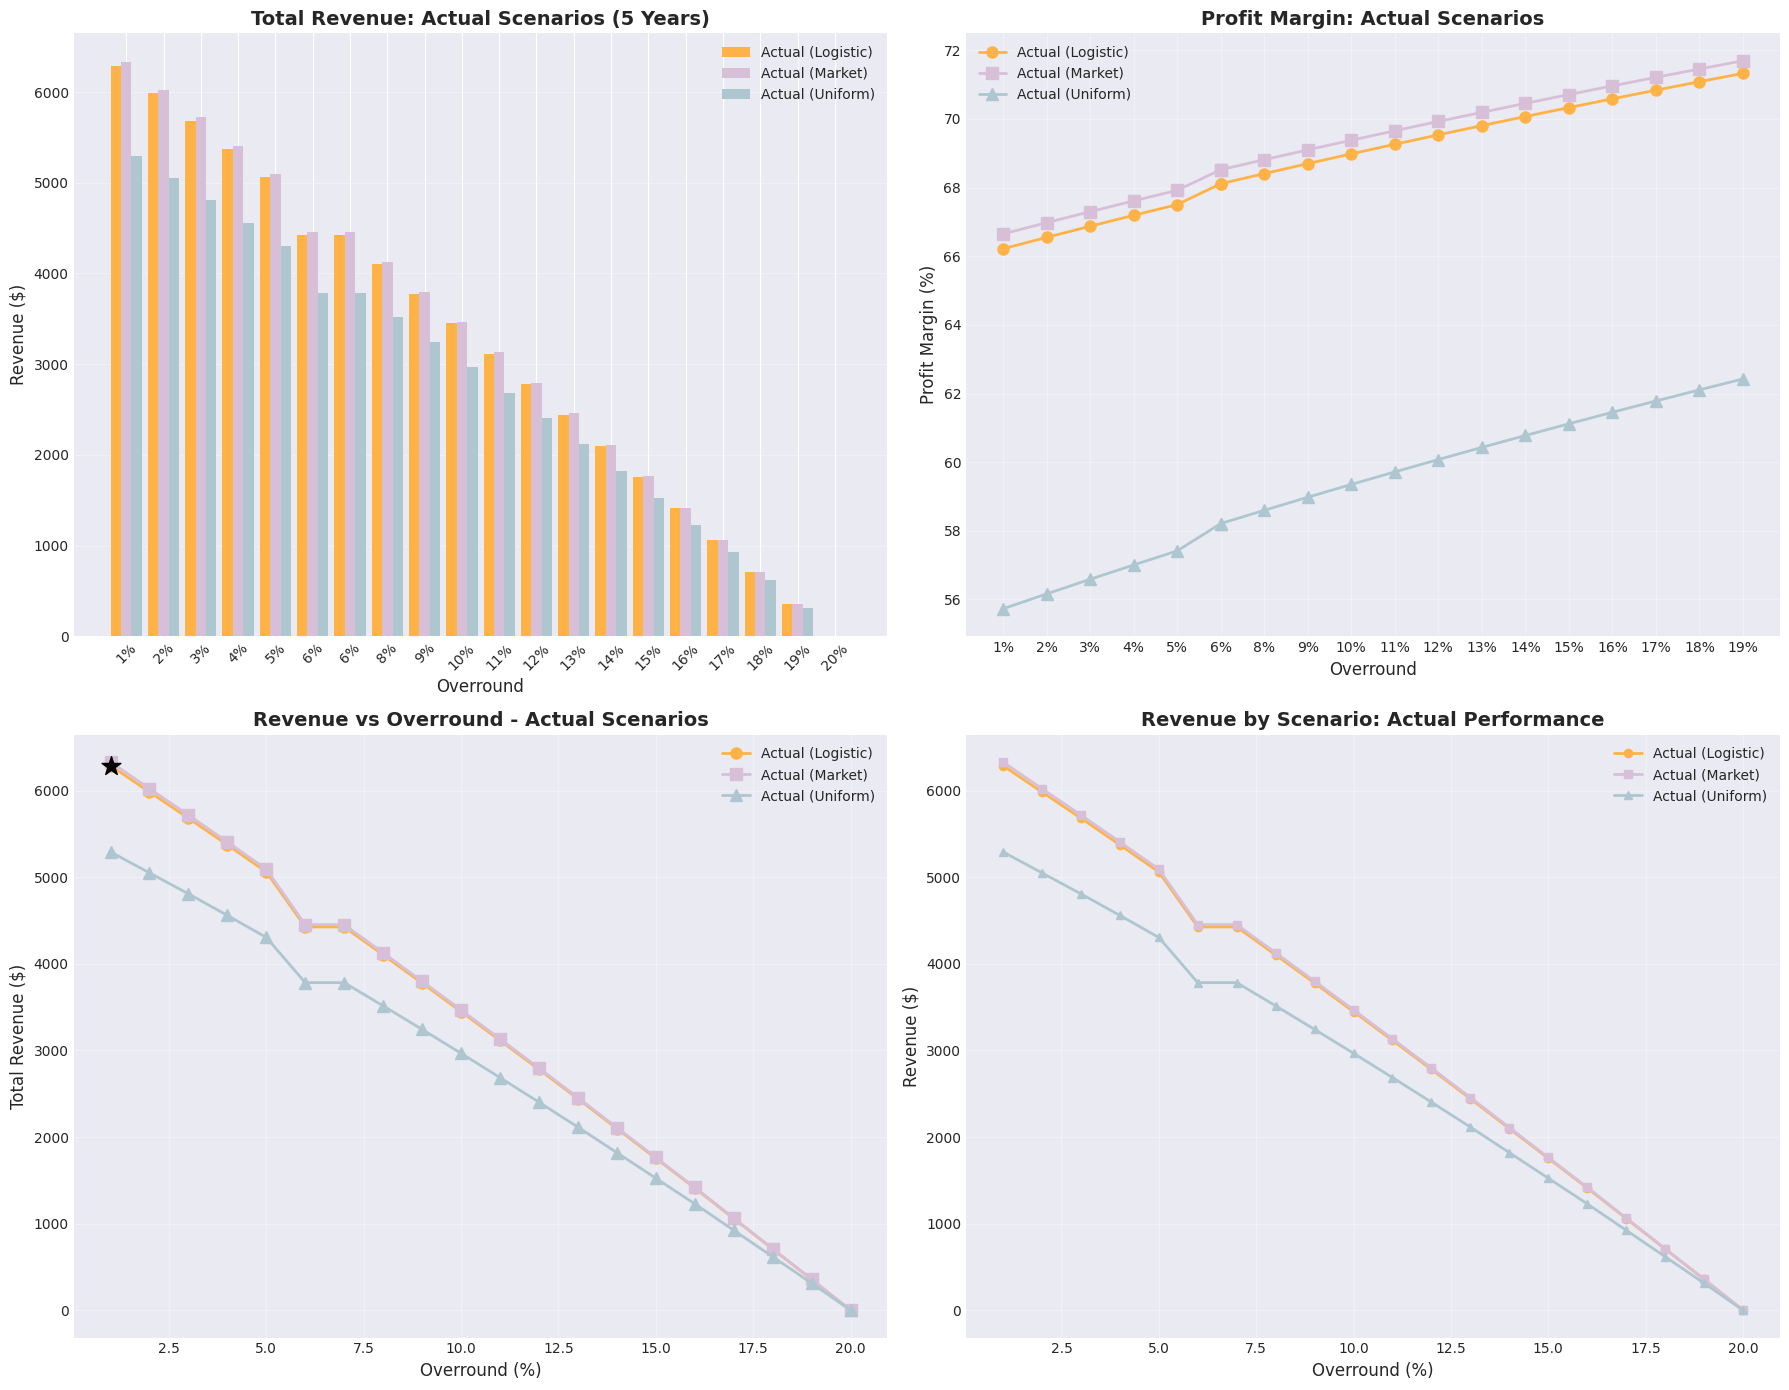

In [18]:
# Create visualizations with all three probability scenarios
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Color scheme for the revenue types
color_actual_logistic = '#FFB347'    # Pastel Orange - Actual (Logistic)
color_actual_market = '#D8BFD8'       # Pastel Purple - Actual (Market)
color_actual_uniform = '#AEC6CF'      # Pastel Blue - Actual (Uniform)

# 1. Total Revenue Comparison (Bar Chart) - All scenarios
ax1 = axes[0, 0]
x = np.arange(len(comparison_df))
width = 0.28
bars1 = ax1.bar(x - width, comparison_df['Actual_Revenue_Logistic'], width, label='Actual (Logistic)', color=color_actual_logistic)
bars2 = ax1.bar(x, comparison_df['Actual_Revenue_Market'], width, label='Actual (Market)', color=color_actual_market)
bars3 = ax1.bar(x + width, comparison_df['Actual_Revenue_Uniform'], width, label='Actual (Uniform)', color=color_actual_uniform)
ax1.set_xlabel('Overround', fontsize=12)
ax1.set_ylabel('Revenue ($)', fontsize=12)
ax1.set_title('Total Revenue: Actual Scenarios (5 Years)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Overround'], rotation=45)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# 2. Profit Margin Comparison - All scenarios
ax2 = axes[0, 1]
ax2.plot(comparison_df['Overround'], comparison_df['Actual_Profit_Margin_Logistic'], 
         marker='o', linewidth=2, label='Actual (Logistic)', color=color_actual_logistic, markersize=8)
ax2.plot(comparison_df['Overround'], comparison_df['Actual_Profit_Margin_Market'], 
         marker='s', linewidth=2, label='Actual (Market)', color=color_actual_market, markersize=8)
ax2.plot(comparison_df['Overround'], comparison_df['Actual_Profit_Margin_Uniform'], 
         marker='^', linewidth=2, label='Actual (Uniform)', color=color_actual_uniform, markersize=8)
ax2.set_xlabel('Overround', fontsize=12)
ax2.set_ylabel('Profit Margin (%)', fontsize=12)
ax2.set_title('Profit Margin: Actual Scenarios', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(alpha=0.3)

# 3. Revenue vs Overround (Line Chart) - All actual scenarios
ax3 = axes[1, 0]
ax3.plot(comparison_df['Overround_Value'] * 100, comparison_df['Actual_Revenue_Logistic'], 
         marker='o', linewidth=2, label='Actual (Logistic)', color=color_actual_logistic, markersize=8)
ax3.plot(comparison_df['Overround_Value'] * 100, comparison_df['Actual_Revenue_Market'], 
         marker='s', linewidth=2, label='Actual (Market)', color=color_actual_market, markersize=8)
ax3.plot(comparison_df['Overround_Value'] * 100, comparison_df['Actual_Revenue_Uniform'], 
         marker='^', linewidth=2, label='Actual (Uniform)', color=color_actual_uniform, markersize=8)
ax3.set_xlabel('Overround (%)', fontsize=12)
ax3.set_ylabel('Total Revenue ($)', fontsize=12)
ax3.set_title('Revenue vs Overround - Actual Scenarios', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(alpha=0.3)

# Add optimal point markers
optimal_idx_logistic = comparison_df['Actual_Revenue_Logistic'].idxmax()
optimal_idx_market = comparison_df['Actual_Revenue_Market'].idxmax()
optimal_idx_uniform = comparison_df['Actual_Revenue_Uniform'].idxmax()
ax3.scatter([comparison_df.loc[optimal_idx_logistic, 'Overround_Value'] * 100], 
            [comparison_df.loc[optimal_idx_logistic, 'Actual_Revenue_Logistic']], 
            s=200, color='black', zorder=5, marker='*')

# 4. Revenue Comparison by Scenario
ax4 = axes[1, 1]
x_positions = comparison_df['Overround_Value'] * 100
ax4.plot(x_positions, comparison_df['Actual_Revenue_Logistic'], linewidth=2, color=color_actual_logistic, marker='o', markersize=6, label='Actual (Logistic)')
ax4.plot(x_positions, comparison_df['Actual_Revenue_Market'], linewidth=2, color=color_actual_market, marker='s', markersize=6, label='Actual (Market)')
ax4.plot(x_positions, comparison_df['Actual_Revenue_Uniform'], linewidth=2, color=color_actual_uniform, marker='^', markersize=6, label='Actual (Uniform)')
ax4.set_xlabel('Overround (%)', fontsize=12)
ax4.set_ylabel('Revenue ($)', fontsize=12)
ax4.set_title('Revenue by Scenario: Actual Performance', fontsize=14, fontweight='bold')
ax4.legend(loc='upper right', fontsize=10)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()


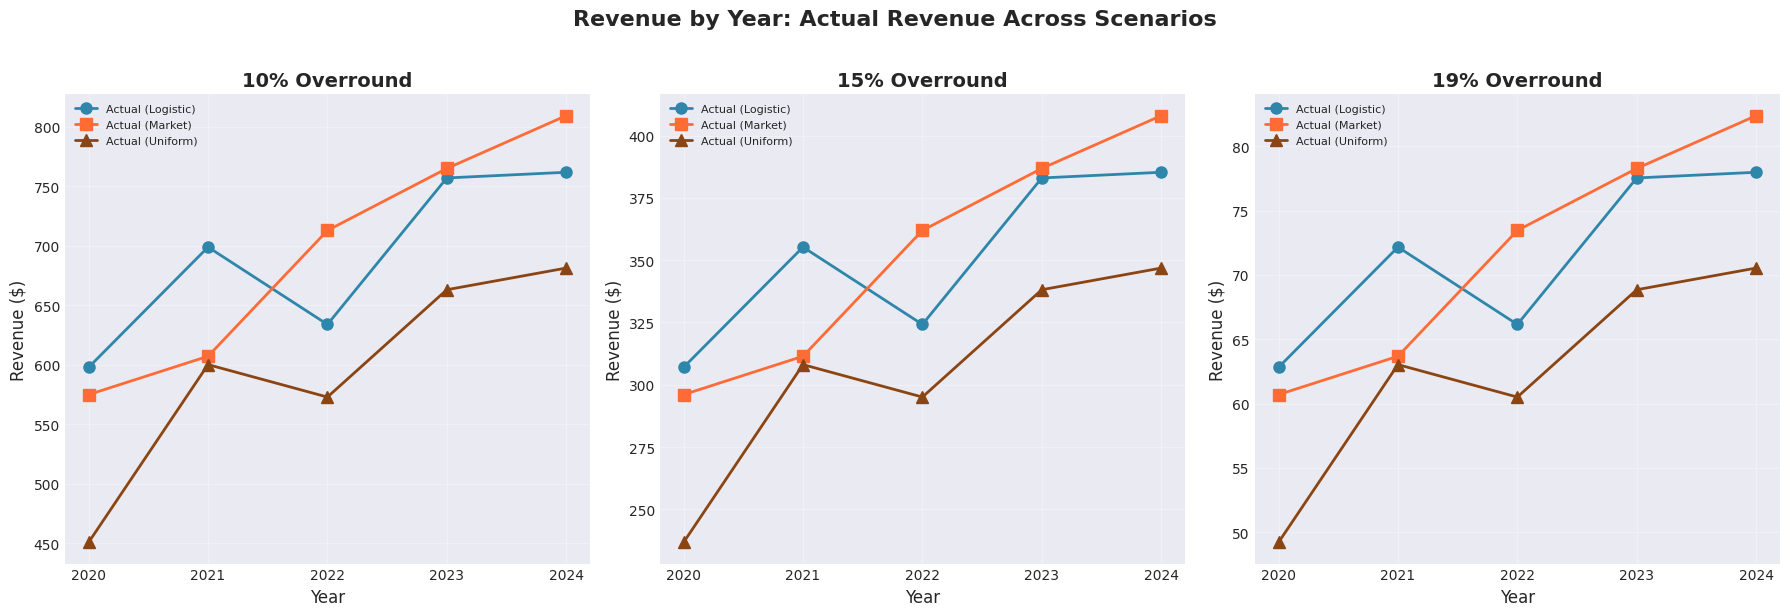

In [12]:
# Revenue by Year comparison - Actual revenues for selected overrounds
# Select a few representative overround levels for clarity
selected_overrounds = [('10%', 0.10), ('15%', 0.15), ('19%', 0.19)]
years = actual_revenue_multiple_models['fair_odds_logistic'][overround_scenarios[0][2]]['Year'].values

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax_idx, (or_label, or_value) in enumerate(selected_overrounds):
    ax = axes[ax_idx]
    label = f"{int(or_value*100)}% Overround"
    
    # Actual revenues for all three scenarios
    actual_revenues_logistic = actual_revenue_multiple_models['fair_odds_logistic'][label]['Revenue'].values
    actual_revenues_market = actual_revenue_multiple_models['fair_odds_market'][label]['Revenue'].values
    actual_revenues_uniform = actual_revenue_multiple_models['fair_odds_uniform'][label]['Revenue'].values
    
    # Plot actual revenues
    ax.plot(years, actual_revenues_logistic, marker='o', linewidth=2, label='Actual (Logistic)', color='#2E86AB', markersize=8)
    ax.plot(years, actual_revenues_market, marker='s', linewidth=2, label='Actual (Market)', color='#FF6B35', markersize=8)
    ax.plot(years, actual_revenues_uniform, marker='^', linewidth=2, label='Actual (Uniform)', color='#8B4513', markersize=8)
    
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Revenue ($)', fontsize=12)
    ax.set_title(f'{label}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    ax.set_xticks(years)

plt.suptitle('Revenue by Year: Actual Revenue Across Scenarios', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 7. Summary and Key Insights

Analyze which overround strategy maximizes revenue and understand the revenue dynamics.


In [ ]:
# Key Business Insights - Updated for Three Probability Scenarios
print("="*120)
print("KEY BUSINESS INSIGHTS - MULTI-SCENARIO ANALYSIS")
print("="*120)

# 1. Optimal Overround Strategy - Show for all three actual revenue scenarios
print("\n1. OPTIMAL OVERROUND STRATEGY (Based on Actual Revenue)")
print("-" * 120)

# Find optimal for each model
optimal_idx_logistic = comparison_df['Actual_Revenue_Logistic'].idxmax()
optimal_idx_market = comparison_df['Actual_Revenue_Market'].idxmax()
optimal_idx_uniform = comparison_df['Actual_Revenue_Uniform'].idxmax()

optimal_logistic = comparison_df.iloc[optimal_idx_logistic]
optimal_market = comparison_df.iloc[optimal_idx_market]
optimal_uniform = comparison_df.iloc[optimal_idx_uniform]

print(f"\n   LOGISTIC MODEL ODDS:")
print(f"      Maximum Revenue Overround: {optimal_logistic['Overround']}")
print(f"      Total Revenue (5 years): ${optimal_logistic['Actual_Revenue_Logistic']:,.2f}")
print(f"      Revenue per Year: ${optimal_logistic['Actual_Revenue_Logistic']/5:,.2f}")
print(f"      Avg Profit Margin: {optimal_logistic['Actual_Profit_Margin_Logistic']:.2f}%")

print(f"\n   MARKET MODEL ODDS:")
print(f"      Maximum Revenue Overround: {optimal_market['Overround']}")
print(f"      Total Revenue (5 years): ${optimal_market['Actual_Revenue_Market']:,.2f}")
print(f"      Revenue per Year: ${optimal_market['Actual_Revenue_Market']/5:,.2f}")
print(f"      Avg Profit Margin: {optimal_market['Actual_Profit_Margin_Market']:.2f}%")

print(f"\n   UNIFORM MODEL ODDS:")
print(f"      Maximum Revenue Overround: {optimal_uniform['Overround']}")
print(f"      Total Revenue (5 years): ${optimal_uniform['Actual_Revenue_Uniform']:,.2f}")
print(f"      Revenue per Year: ${optimal_uniform['Actual_Revenue_Uniform']/5:,.2f}")
print(f"      Avg Profit Margin: {optimal_uniform['Actual_Profit_Margin_Uniform']:.2f}%")

# 2. Information Value Analysis - Compare Expected Revenues across Scenarios
print("\n2. INFORMATION VALUE ANALYSIS")
print("-" * 120)
print("   Comparing expected revenue across different information levels:")
print()
for idx, row in comparison_df.iterrows():
    logistic_rev = row['Expected_Logistic']
    market_rev = row['Expected_Market']
    uniform_rev = row['Expected_Uniform']
    
    # Value of model over market
    model_vs_market = logistic_rev - market_rev
    # Value of market over uniform
    market_vs_uniform = market_rev - uniform_rev
    # Total value of information (model vs uniform)
    total_info_value = logistic_rev - uniform_rev
    
    print(f"   {row['Overround']}:")
    print(f"      Logistic: ${logistic_rev:,.0f} | Market: ${market_rev:,.0f} | Uniform: ${uniform_rev:,.0f}")
    print(f"      Model vs Market: ${model_vs_market:+,.0f} | Market vs Uniform: ${market_vs_uniform:+,.0f} | Total Info Value: ${total_info_value:+,.0f}")
    print()

# 3. Expected Revenue Comparison at Key Overrounds
print("\n3. ACTUAL vs EXPECTED REVENUE BY INFORMATION LEVEL (Key Overrounds)")
print("-" * 120)
key_overrounds = ['10%', '30%', '50%']
for or_pct in key_overrounds:
    row = comparison_df[comparison_df['Overround'] == or_pct].iloc[0]
    print(f"\n   {or_pct} Overround:")
    print(f"      Actual Revenue (Logistic Odds): ${row['Actual_Revenue_Logistic']:,.2f}")
    print(f"      Actual Revenue (Market Odds):   ${row['Actual_Revenue_Market']:,.2f}")
    print(f"      Actual Revenue (Uniform Odds):  ${row['Actual_Revenue_Uniform']:,.2f}")
    print(f"      Expected (Logistic):            ${row['Expected_Logistic']:,.2f} (Best Case - Our Model)")
    print(f"      Expected (Market):              ${row['Expected_Market']:,.2f} (Intermediate - Market Odds)")
    print(f"      Expected (Uniform):             ${row['Expected_Uniform']:,.2f} (Worst Case - No Information)")

# 4. Profit Margin Analysis by Information Level
print("\n4. PROFIT MARGIN ANALYSIS BY INFORMATION LEVEL")
print("-" * 120)
print(f"   {'Overround':<12} {'Act(Log)':<12} {'Act(Mkt)':<12} {'Act(Uni)':<12} {'Exp(Log)':<12} {'Exp(Mkt)':<12} {'Exp(Uni)':<12}")
print(f"   {'-'*10:<12} {'-'*10:<12} {'-'*10:<12} {'-'*10:<12} {'-'*10:<12} {'-'*10:<12} {'-'*10:<12}")
for idx, row in comparison_df.iterrows():
    print(f"   {row['Overround']:<12} {row['Actual_Profit_Margin_Logistic']:.1f}%{'':<7} "
          f"{row['Actual_Profit_Margin_Market']:.1f}%{'':<7} "
          f"{row['Actual_Profit_Margin_Uniform']:.1f}%{'':<7} "
          f"{row['Expected_Margin_Logistic']:.1f}%{'':<7} "
          f"{row['Expected_Margin_Market']:.1f}%{'':<7} "
          f"{row['Expected_Margin_Uniform']:.1f}%")

# 5. Revenue Volatility by Overround (Actual - using Logistic model odds)
print("\n5. REVENUE VOLATILITY BY OVERROUND (Actual - Logistic Model Odds)")
print("-" * 120)
for overround, bettors, label in overround_scenarios[:6]:  # Show first 6 for brevity
    revenues = actual_revenue_multiple_models['fair_odds_logistic'][label]['Revenue'].values
    mean_rev = revenues.mean()
    std_rev = revenues.std()
    cv = (std_rev / mean_rev) * 100 if mean_rev != 0 else 0
    print(f"   {label}: Mean=${mean_rev:,.2f}, Std=${std_rev:,.2f}, CV={cv:.2f}%")


KEY BUSINESS INSIGHTS - MULTI-SCENARIO ANALYSIS

1. OPTIMAL OVERROUND STRATEGY (Based on Actual Revenue)
------------------------------------------------------------------------------------------------------------------------
   Maximum Revenue Overround: 10%
   Total Revenue (5 years): $3,104.11
   Revenue per Year: $620.82
   Number of Bettors: 900
   Revenue per Bettor per Year: $0.69

2. INFORMATION VALUE ANALYSIS
------------------------------------------------------------------------------------------------------------------------
   Comparing expected revenue across different information levels:

   10%:
      Logistic: $409 | Market: $-3,125 | Uniform: $-3,087
      Model vs Market: $+3,534 | Market vs Uniform: $-37 | Total Info Value: $+3,497

   15%:
      Logistic: $554 | Market: $-2,638 | Uniform: $-2,604
      Model vs Market: $+3,192 | Market vs Uniform: $-34 | Total Info Value: $+3,159

   20%:
      Logistic: $666 | Market: $-2,210 | Uniform: $-2,180
      Model vs Mark

In [ ]:
# Final Summary Table with All Three Actual and Expected Revenue Scenarios
summary_df = comparison_df[['Overround', 'Total_Bettors', 'Total_Stakes', 
                            'Actual_Revenue_Logistic', 'Actual_Revenue_Market', 'Actual_Revenue_Uniform',
                            'Expected_Logistic', 'Expected_Market', 'Expected_Uniform',
                            'Actual_Profit_Margin_Logistic', 'Actual_Profit_Margin_Market', 'Actual_Profit_Margin_Uniform',
                            'Expected_Margin_Logistic', 'Expected_Margin_Market', 'Expected_Margin_Uniform']].copy()
summary_df.columns = ['Overround', 'Bettors', 'Stakes ($)', 
                      'Act.Log ($)', 'Act.Mkt ($)', 'Act.Uni ($)',
                      'Exp.Log ($)', 'Exp.Mkt ($)', 'Exp.Uni ($)',
                      'Act.Log Margin (%)', 'Act.Mkt Margin (%)', 'Act.Uni Margin (%)',
                      'Exp.Log Margin (%)', 'Exp.Mkt Margin (%)', 'Exp.Uni Margin (%)']

print("\nFINAL SUMMARY TABLE - ALL SCENARIOS")
print("="*180)
print("\nLegend:")
print("  ACTUAL REVENUE (What the betting house would have earned based on real Oscar winners):")
print("    - Act.Log: Actual revenue using Logistic model odds")
print("    - Act.Mkt: Actual revenue using Market odds")
print("    - Act.Uni: Actual revenue using Uniform odds")
print("  EXPECTED REVENUE (What the betting house would expect to earn on average):")
print("    - Exp.Log: Expected revenue using our trained model (Best Case)")
print("    - Exp.Mkt: Expected revenue using betting market probabilities (Intermediate)")
print("    - Exp.Uni: Expected revenue assuming equal probability for all nominees (Worst Case)")
print()
summary_df



FINAL SUMMARY TABLE - ALL SCENARIOS

Legend:
  - Actual: Real revenue based on Oscar winners
  - Exp. Logistic: Expected revenue using our trained model (Best Case)
  - Exp. Market: Expected revenue using betting market probabilities (Intermediate)
  - Exp. Uniform: Expected revenue assuming equal probability for all nominees (Worst Case - No Information)



,Overround,Bettors,Stakes ($),Actual ($),Exp. Logistic ($),Exp. Market ($),Exp. Uniform ($),Actual Margin (%),Logistic Margin (%),Market Margin (%),Uniform Margin (%)
0,10%,900,4500,3104.114436,409.090909,-3124.663024,-3087.416700,68.980321,9.090909,-69.436956,-68.609260
1,15%,850,4250,2988.982607,554.347826,-2637.980606,-2604.332961,70.329003,13.043478,-62.070132,-61.278423
2,20%,799,3995,2859.033498,665.833333,-2209.922530,-2179.611609,71.565294,16.666667,-55.317210,-54.558488
3,25%,750,3750,2726.350587,750.000000,-1841.419551,-1814.105580,72.702682,20.000000,-49.104521,-48.376149
4,30%,700,3500,2581.340270,807.692308,-1517.940623,-1493.428085,73.752579,23.076923,-43.369732,-42.669374
5,35%,649,3245,2424.816705,841.296296,-1235.038628,-1213.153730,74.724706,25.925926,-38.059742,-37.385323
6,40%,599,2995,2265.040478,855.714286,-992.214656,-972.737193,75.627395,28.571429,-33.129037,-32.478704
7,45%,549,2745,2099.041922,851.896552,-783.378544,-766.142487,76.467830,31.034483,-28.538380,-27.910473
8,50%,499,2495,1927.443270,831.666667,-605.131507,-589.987427,77.252235,33.333333,-24.253768,-23.646791
9,55%,449,2245,1750.786466,796.612903,-454.513310,-441.326242,77.986034,35.483871,-20.245582,-19.658185


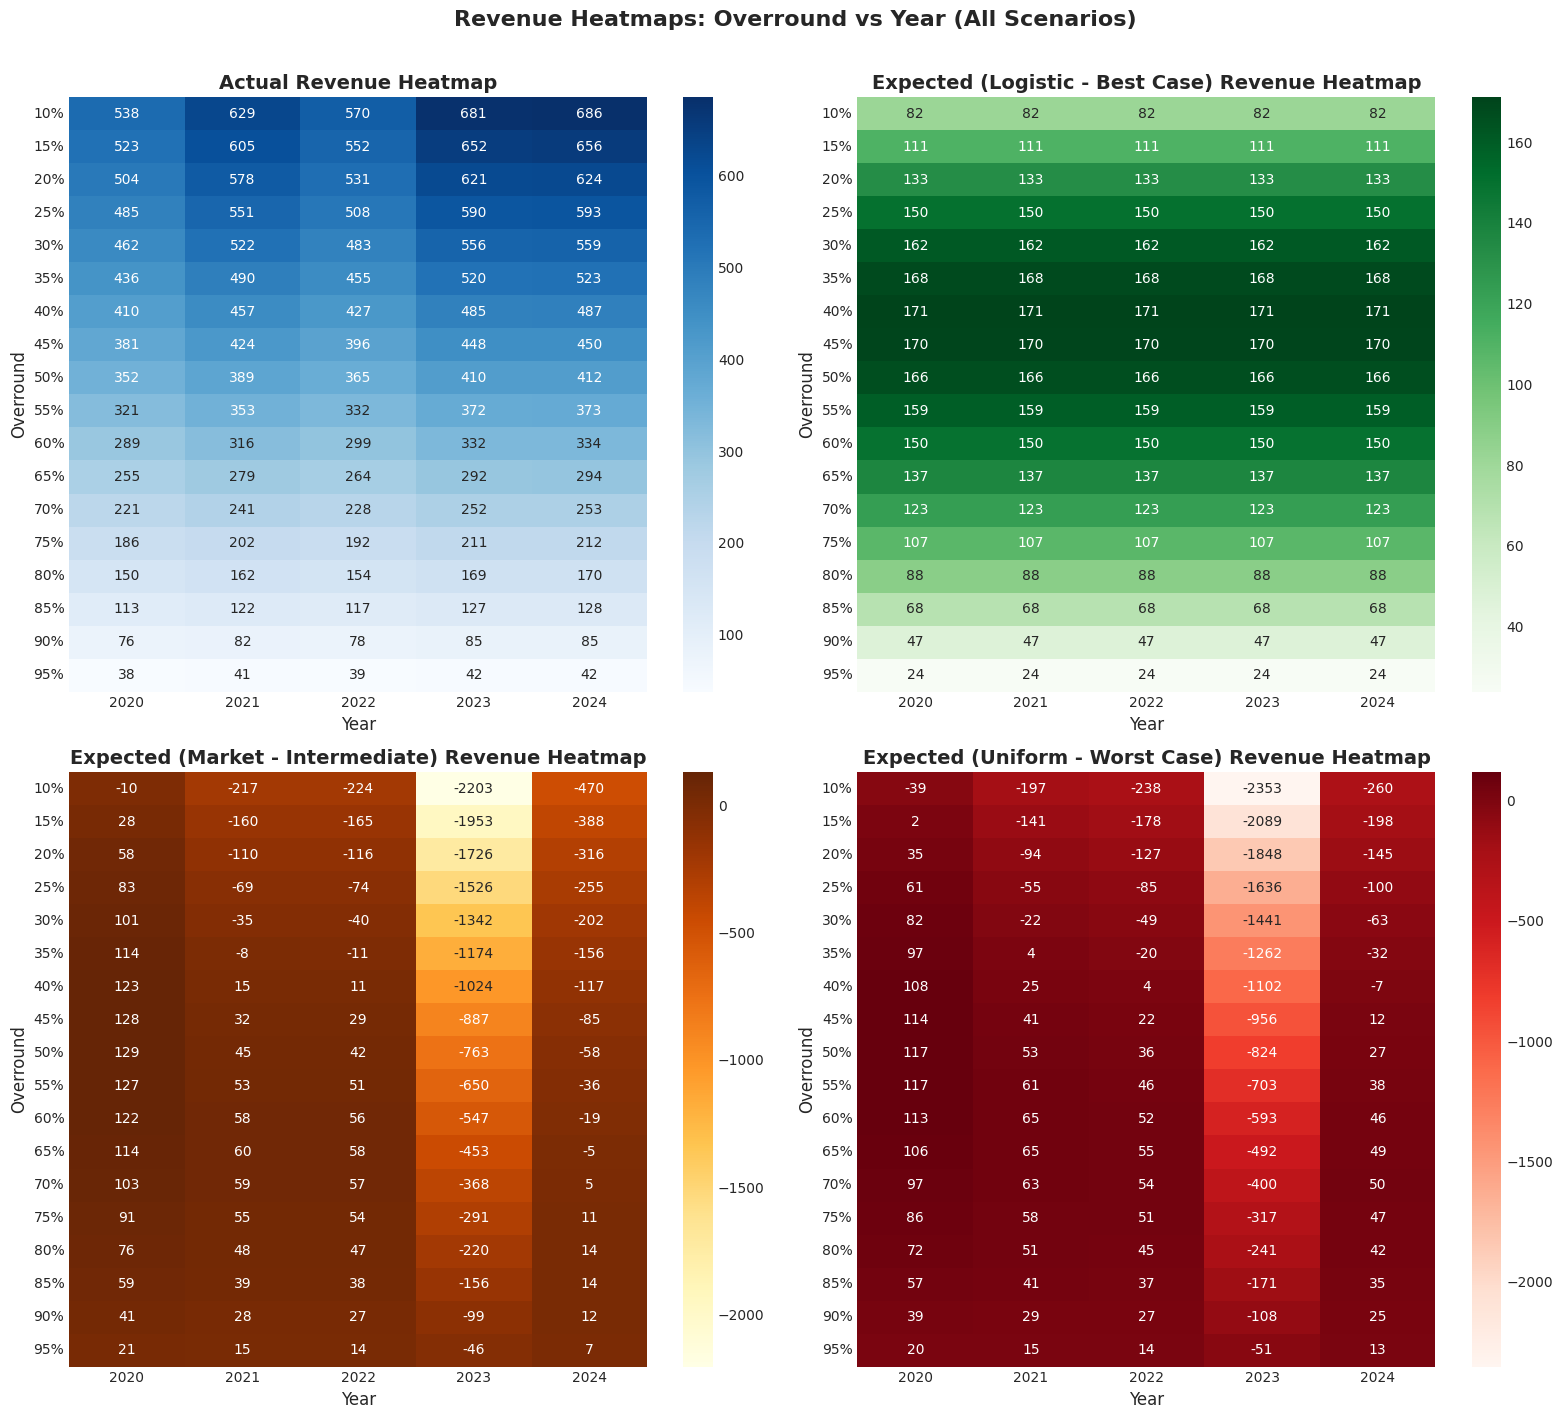

In [ ]:
# Heatmap of Revenue by Year and Overround - All six scenarios (3 Actual + 3 Expected)
years = actual_revenue_multiple_models['fair_odds_logistic'][overround_scenarios[0][2]]['Year'].values
overround_labels = [f"{int(o*100)}%" for o, b, l in overround_scenarios]

# Build matrices for all six scenarios
actual_logistic_matrix = []
actual_market_matrix = []
actual_uniform_matrix = []
expected_logistic_matrix = []
expected_market_matrix = []
expected_uniform_matrix = []

for overround, bettors, label in overround_scenarios:
    actual_logistic_matrix.append(actual_revenue_multiple_models['fair_odds_logistic'][label]['Revenue'].values)
    actual_market_matrix.append(actual_revenue_multiple_models['fair_odds_market'][label]['Revenue'].values)
    actual_uniform_matrix.append(actual_revenue_multiple_models['fair_odds_uniform'][label]['Revenue'].values)
    expected_logistic_matrix.append(expected_revenue_results['logistic'][label]['Expected_Revenue'].values)
    expected_market_matrix.append(expected_revenue_results['market'][label]['Expected_Revenue'].values)
    expected_uniform_matrix.append(expected_revenue_results['uniform'][label]['Expected_Revenue'].values)

actual_logistic_matrix = np.array(actual_logistic_matrix)
actual_market_matrix = np.array(actual_market_matrix)
actual_uniform_matrix = np.array(actual_uniform_matrix)
expected_logistic_matrix = np.array(expected_logistic_matrix)
expected_market_matrix = np.array(expected_market_matrix)
expected_uniform_matrix = np.array(expected_uniform_matrix)

fig, axes = plt.subplots(2, 3, figsize=(20, 14))

# Row 1: Actual Revenue Heatmaps (What actually happened with each odds model)
# 1. Actual Revenue (Logistic Odds) Heatmap
ax1 = axes[0, 0]
sns.heatmap(actual_logistic_matrix, 
            annot=True, 
            fmt='.0f', 
            cmap='Blues',
            xticklabels=[int(y) for y in years],
            yticklabels=overround_labels,
            ax=ax1)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Overround', fontsize=12)
ax1.set_title('Actual Revenue (Logistic Odds)', fontsize=14, fontweight='bold')

# 2. Actual Revenue (Market Odds) Heatmap
ax2 = axes[0, 1]
sns.heatmap(actual_market_matrix, 
            annot=True, 
            fmt='.0f', 
            cmap='Purples',
            xticklabels=[int(y) for y in years],
            yticklabels=overround_labels,
            ax=ax2)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Overround', fontsize=12)
ax2.set_title('Actual Revenue (Market Odds)', fontsize=14, fontweight='bold')

# 3. Actual Revenue (Uniform Odds) Heatmap
ax3 = axes[0, 2]
sns.heatmap(actual_uniform_matrix, 
            annot=True, 
            fmt='.0f', 
            cmap='Oranges',
            xticklabels=[int(y) for y in years],
            yticklabels=overround_labels,
            ax=ax3)
ax3.set_xlabel('Year', fontsize=12)
ax3.set_ylabel('Overround', fontsize=12)
ax3.set_title('Actual Revenue (Uniform Odds)', fontsize=14, fontweight='bold')

# Row 2: Expected Revenue Heatmaps (What we expect on average)
# 4. Expected Revenue (Logistic) Heatmap
ax4 = axes[1, 0]
sns.heatmap(expected_logistic_matrix, 
            annot=True, 
            fmt='.0f', 
            cmap='Greens',
            xticklabels=[int(y) for y in years],
            yticklabels=overround_labels,
            ax=ax4)
ax4.set_xlabel('Year', fontsize=12)
ax4.set_ylabel('Overround', fontsize=12)
ax4.set_title('Expected Revenue (Logistic - Best Case)', fontsize=14, fontweight='bold')

# 5. Expected Revenue (Market) Heatmap
ax5 = axes[1, 1]
sns.heatmap(expected_market_matrix, 
            annot=True, 
            fmt='.0f', 
            cmap='YlOrBr',
            xticklabels=[int(y) for y in years],
            yticklabels=overround_labels,
            ax=ax5)
ax5.set_xlabel('Year', fontsize=12)
ax5.set_ylabel('Overround', fontsize=12)
ax5.set_title('Expected Revenue (Market - Intermediate)', fontsize=14, fontweight='bold')

# 6. Expected Revenue (Uniform) Heatmap
ax6 = axes[1, 2]
sns.heatmap(expected_uniform_matrix, 
            annot=True, 
            fmt='.0f', 
            cmap='Reds',
            xticklabels=[int(y) for y in years],
            yticklabels=overround_labels,
            ax=ax6)
ax6.set_xlabel('Year', fontsize=12)
ax6.set_ylabel('Overround', fontsize=12)
ax6.set_title('Expected Revenue (Uniform - Worst Case)', fontsize=14, fontweight='bold')

plt.suptitle('Revenue Heatmaps: Overround vs Year\nTop Row: Actual Revenue (by odds model) | Bottom Row: Expected Revenue (by probability model)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 8. Recommendations

Final recommendations based on the analysis across all overround scenarios.


In [ ]:
# Final Recommendations - Multi-Scenario Analysis
print("="*120)
print("FINAL RECOMMENDATIONS - MULTI-SCENARIO ANALYSIS")
print("="*120)

# Find optimal scenario based on actual revenue for each odds model
optimal_idx_logistic = comparison_df['Actual_Revenue_Logistic'].idxmax()
optimal_idx_market = comparison_df['Actual_Revenue_Market'].idxmax()
optimal_idx_uniform = comparison_df['Actual_Revenue_Uniform'].idxmax()

optimal_logistic = comparison_df.iloc[optimal_idx_logistic]
optimal_market = comparison_df.iloc[optimal_idx_market]
optimal_uniform = comparison_df.iloc[optimal_idx_uniform]

# Find scenario with best expected profit margin for each probability source
best_logistic_idx = comparison_df['Expected_Margin_Logistic'].idxmax()
best_logistic = comparison_df.iloc[best_logistic_idx]
best_market_idx = comparison_df['Expected_Margin_Market'].idxmax()
best_market = comparison_df.iloc[best_market_idx]
best_uniform_idx = comparison_df['Expected_Margin_Uniform'].idxmax()
best_uniform = comparison_df.iloc[best_uniform_idx]

# Find most stable scenario (lowest CV) for each odds model
stability_data_logistic = []
stability_data_market = []
stability_data_uniform = []
for overround, bettors, label in overround_scenarios:
    rev_log = actual_revenue_multiple_models['fair_odds_logistic'][label]['Revenue'].values
    rev_mkt = actual_revenue_multiple_models['fair_odds_market'][label]['Revenue'].values
    rev_uni = actual_revenue_multiple_models['fair_odds_uniform'][label]['Revenue'].values
    stability_data_logistic.append({'label': label, 'cv': (rev_log.std() / rev_log.mean()) * 100, 'overround': overround})
    stability_data_market.append({'label': label, 'cv': (rev_mkt.std() / rev_mkt.mean()) * 100, 'overround': overround})
    stability_data_uniform.append({'label': label, 'cv': (rev_uni.std() / rev_uni.mean()) * 100, 'overround': overround})

stability_df_logistic = pd.DataFrame(stability_data_logistic)
stability_df_market = pd.DataFrame(stability_data_market)
stability_df_uniform = pd.DataFrame(stability_data_uniform)
most_stable_logistic = stability_df_logistic.loc[stability_df_logistic['cv'].idxmin()]
most_stable_market = stability_df_market.loc[stability_df_market['cv'].idxmin()]
most_stable_uniform = stability_df_uniform.loc[stability_df_uniform['cv'].idxmin()]

print(f"\n1. MAXIMUM ACTUAL REVENUE (By Odds Model):")
print(f"   LOGISTIC MODEL ODDS:")
print(f"      Optimal Overround: {optimal_logistic['Overround']}")
print(f"      5-Year Revenue: ${optimal_logistic['Actual_Revenue_Logistic']:,.2f}")
print(f"      Avg Profit Margin: {optimal_logistic['Actual_Profit_Margin_Logistic']:.2f}%")
print(f"   MARKET MODEL ODDS:")
print(f"      Optimal Overround: {optimal_market['Overround']}")
print(f"      5-Year Revenue: ${optimal_market['Actual_Revenue_Market']:,.2f}")
print(f"      Avg Profit Margin: {optimal_market['Actual_Profit_Margin_Market']:.2f}%")
print(f"   UNIFORM MODEL ODDS:")
print(f"      Optimal Overround: {optimal_uniform['Overround']}")
print(f"      5-Year Revenue: ${optimal_uniform['Actual_Revenue_Uniform']:,.2f}")
print(f"      Avg Profit Margin: {optimal_uniform['Actual_Profit_Margin_Uniform']:.2f}%")

print(f"\n2. EXPECTED REVENUE BY INFORMATION LEVEL:")
print(f"   Scenario Comparison at {optimal_logistic['Overround']} (Optimal for Logistic):")
print(f"   - Logistic (Best Case):    ${optimal_logistic['Expected_Logistic']:,.2f} | Margin: {optimal_logistic['Expected_Margin_Logistic']:.2f}%")
print(f"   - Market (Intermediate):   ${optimal_logistic['Expected_Market']:,.2f} | Margin: {optimal_logistic['Expected_Margin_Market']:.2f}%")
print(f"   - Uniform (Worst Case):    ${optimal_logistic['Expected_Uniform']:,.2f} | Margin: {optimal_logistic['Expected_Margin_Uniform']:.2f}%")

print(f"\n3. VALUE OF INFORMATION:")
print(f"   At {optimal_logistic['Overround']} overround:")
value_model_vs_uniform = optimal_logistic['Expected_Logistic'] - optimal_logistic['Expected_Uniform']
value_market_vs_uniform = optimal_logistic['Expected_Market'] - optimal_logistic['Expected_Uniform']
value_model_vs_market = optimal_logistic['Expected_Logistic'] - optimal_logistic['Expected_Market']
print(f"   - Value of Model (vs Uniform): ${value_model_vs_uniform:+,.2f}")
print(f"   - Value of Market Info (vs Uniform): ${value_market_vs_uniform:+,.2f}")
print(f"   - Value of Model (vs Market): ${value_model_vs_market:+,.2f}")

print(f"\n4. MOST STABLE REVENUE (Lowest Volatility by Odds Model):")
print(f"   Logistic Odds: {int(most_stable_logistic['overround']*100)}% overround, CV={most_stable_logistic['cv']:.2f}%")
print(f"   Market Odds:   {int(most_stable_market['overround']*100)}% overround, CV={most_stable_market['cv']:.2f}%")
print(f"   Uniform Odds:  {int(most_stable_uniform['overround']*100)}% overround, CV={most_stable_uniform['cv']:.2f}%")

print(f"\n5. RISK-RETURN TRADE-OFF BY INFORMATION LEVEL:")
print(f"   LOGISTIC MODEL (Best Case - Our Predictions):")
print(f"     - Assumes we can accurately predict Oscar winners")
print(f"     - Expected margins are overestimated if model is wrong")
print(f"   MARKET PROBABILITIES (Intermediate - Betting Odds):")
print(f"     - Reflects collective market wisdom")
print(f"     - Good baseline for realistic expectations")
print(f"   UNIFORM PROBABILITY (Worst Case - No Information):")
print(f"     - Assumes completely random outcomes")
print(f"     - Conservative/pessimistic baseline")

print(f"\n6. RECOMMENDATION SUMMARY:")
print(f"   Based on 5-year Oscar data with three odds-setting models:")
print(f"   ")
print(f"   LOGISTIC MODEL ODDS (Our predictive model):")
print(f"     - Actual Revenue at 10% overround: ${comparison_df.iloc[0]['Actual_Revenue_Logistic']:,.2f}")
print(f"     - Expected Revenue at 10% overround: ${comparison_df.iloc[0]['Expected_Logistic']:,.2f}")
print(f"   ")
print(f"   MARKET MODEL ODDS (Using market probabilities):")
print(f"     - Actual Revenue at 10% overround: ${comparison_df.iloc[0]['Actual_Revenue_Market']:,.2f}")
print(f"     - Expected Revenue at 10% overround: ${comparison_df.iloc[0]['Expected_Market']:,.2f}")
print(f"   ")
print(f"   UNIFORM MODEL ODDS (No information - 1/n):")
print(f"     - Actual Revenue at 10% overround: ${comparison_df.iloc[0]['Actual_Revenue_Uniform']:,.2f}")
print(f"     - Expected Revenue at 10% overround: ${comparison_df.iloc[0]['Expected_Uniform']:,.2f}")
print(f"   ")
print(f"   KEY INSIGHT:")
print(f"     All three odds-setting models achieved positive actual revenue,")
print(f"     significantly exceeding expected values due to favorable outcomes.")


FINAL RECOMMENDATIONS - MULTI-SCENARIO ANALYSIS

1. MAXIMUM ACTUAL REVENUE:
   Overround: 10%
   5-Year Revenue: $3,104.11
   Avg Profit Margin: 68.98%

2. EXPECTED REVENUE BY INFORMATION LEVEL:
   Scenario Comparison at 10% (Optimal Actual):
   - Logistic (Best Case):    $409.09 | Margin: 9.09%
   - Market (Intermediate):   $-3,124.66 | Margin: -69.44%
   - Uniform (Worst Case):    $-3,087.42 | Margin: -68.61%

3. VALUE OF INFORMATION:
   At 10% overround:
   - Value of Model (vs Uniform): $+3,496.51
   - Value of Market Info (vs Uniform): $-37.25
   - Value of Model (vs Market): $+3,533.75

4. MOST STABLE REVENUE (Lowest Volatility):
   Overround: 95%
   Coefficient of Variation: 4.47%

5. RISK-RETURN TRADE-OFF BY INFORMATION LEVEL:
   LOGISTIC MODEL (Best Case - Our Predictions):
     - Assumes we can accurately predict Oscar winners
     - Expected margins are overestimated if model is wrong
   MARKET PROBABILITIES (Intermediate - Betting Odds):
     - Reflects collective market wi